In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

# load processed data
sector = 'ZTL'
file_path = glob.glob('../data_preprocessing/processed_features/{}*'.format(sector))
pdf3 = pd.concat(map(pd.read_csv, file_path))
pdf3 = pdf3[pdf3['arr_time']<3500]
pdf3

,Unnamed: 0,recTime,time,round-60,round-30,round-15,acId,lat,lon,alt,...,EV_LOOP_600,EV_LOOP_1800,EV_LOOP_3600,EV_GOA_600,EV_GOA_1800,EV_GOA_3600,arr_time,time200,time100,time40
0,811,1564634536,2019-08-01 00:42:16,0,1,2,DAL2690,34.82167,-83.00944,380.0,...,0,0,0,0,0,0,483,1564633694,1564634536,1564635019
1,1300,1564634291,2019-08-01 00:38:11,0,1,2,AAL2290,32.45111,-83.06111,271.0,...,0,0,0,0,0,0,556,1564633501,1564634291,1564634847
2,8042,1564636402,2019-08-01 01:13:22,1,2,4,SWA2474,32.86306,-86.17028,376.0,...,0,0,0,0,0,0,525,1564635585,1564636402,1564636927
3,8300,1564636436,2019-08-01 01:13:56,1,2,4,DAL1777,34.97583,-85.61972,330.0,...,0,0,0,0,0,0,470,1564635697,1564636436,1564636906
4,9515,1564637031,2019-08-01 01:23:51,1,2,5,JBU997,34.81389,-82.99806,247.0,...,0,0,0,0,0,0,550,1564636190,1564637031,1564637581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2047749,1567138069,2019-08-30 00:07:49,0,0,0,SWA2258,32.89750,-86.21139,294.0,...,0,0,5,0,0,1,586,1567137301,1567138069,1567138655
984,2050306,1567138480,2019-08-30 00:14:40,0,0,0,NKS230,32.45500,-83.05528,335.0,...,0,0,2,0,0,0,523,1567137641,1567138480,1567139003
985,2050560,1567138556,2019-08-30 00:15:56,0,0,1,SWA1640,34.26778,-86.26528,310.0,...,0,0,2,0,0,0,497,1567137798,1567138556,1567139053
986,2053132,1567139080,2019-08-30 00:24:40,0,0,1,NKS676,32.44889,-83.04944,330.0,...,0,0,2,0,0,0,459,1567138289,1567139080,1567139539


## Grid Search with H2o 
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-search-in-python

### GRID SEARCH 1

In [32]:
h2o.init()
hf = h2o.H2OFrame(pdf3)
predictors = ['round-15', 'lat', 'lon', 'alt', 'Dest', 'distance', 'acType', 'groundSpeed', 'distance', 
            '#AC_10mins_ahead', '#AC_10mins_behind', '#AC_30mins_ahead', '#AC_30mins_behind', '#AC_60mins_ahead', '#AC_60mins_behind', 
            'EV_RRT_600', 'EV_RRT_1800', 'EV_RRT_3600', 'EV_LOOP_600', 'EV_LOOP_1800', 'EV_LOOP_3600', 'EV_GOA_600', 'EV_GOA_1800', 'EV_GOA_3600', ]

response = "arr_time"

valid, train = hf.split_frame(ratios = [.2], seed = 1234)

# Grid Search Model
gbm_params1 = {'learn_rate': [0.05, 0.1],
                'max_depth': [7, 8, 9, 10, 11, 12],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 0.6, 0.7, 0.8]}

# Train and validate a cartesian grid of GBMs
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)

gbm_grid1.train(x=predictors, 
                y=response,
                training_frame=train,
                validation_frame=valid,
                ntrees=100,
                seed=1234)

# show best grid
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='rmsle', decreasing=False)

best_model1 = gbm_gridperf1.models[0]

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,15 mins 26 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 year and 25 days !!!
H2O_cluster_name:,H2O_from_python_ypang6_txvb3d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.23 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [33]:
gbm_gridperf1

        col_sample_rate  learn_rate  max_depth  sample_rate  \
0                   0.5        0.05       12.0          1.0   
1                   0.5        0.05       12.0          1.0   
2                   0.5        0.05       10.0          1.0   
3                   0.7        0.10       11.0          1.0   
4                   0.6        0.10       11.0          0.8   
..  ..              ...         ...        ...          ...   
187                 0.8        0.10        9.0          0.8   
188                 0.7        0.10       11.0          0.8   
189                 0.8        0.10       12.0          0.8   
190                 0.8        0.10       11.0          0.8   
191                 0.7        0.10       12.0          0.8   

               model_ids     rmsle  
0    gbm_grid1_model_185  0.097850  
1     gbm_grid1_model_89  0.098487  
2     gbm_grid1_model_73  0.098571  
3     gbm_grid1_model_87  0.098602  
4    gbm_grid1_model_134  0.098615  
..                   

In [34]:
perf1 = best_model1.model_performance(valid)
perf1


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 8215.515921980512
RMSE: 90.63948323981394
MAE: 36.12422155102006
RMSLE: 0.09784981538344002
Mean Residual Deviance: 8215.515921980512


In [35]:
valid.shape

(5673, 33)

### Draw Model Predictions

#### Training Set

In [ ]:
# retrieve the model performance
pred = best_model1.predict(train)
validpd = h2o.as_list(train)

fig, ax = plt.subplots(figsize=(20, 5))
x = np.arange(len(validpd))
plt.scatter(x, validpd['arr_time'].tolist(), s=3, alpha=0.5, label='GTs')
predpd = h2o.as_list(pred)
plt.scatter(x, predpd['predict'].tolist(), s=3, alpha=0.5, label='Predictions')

plt.legend()
plt.savefig('result_RF_training', dpi=300)

#### Validation Set

In [ ]:
# retrieve the model performance
pred1 = best_model1.predict(valid)
validpd1 = h2o.as_list(valid)
predpd1 = h2o.as_list(pred1)

fig, ax = plt.subplots(figsize=(20, 5))
x = np.arange(len(validpd1))
plt.scatter(x, validpd1['arr_time'].tolist(), s=3, alpha=0.5, label='GTs')
plt.scatter(x, predpd1['predict'].tolist(), s=3, alpha=0.5, label='Predictions')

plt.legend()
plt.savefig('result_RF_validation', dpi=300)

In [ ]:
# validation on EV_LOOP_600>10
valid1_10_40 = valid[(valid['EV_LOOP_600']>10)&valid['EV_LOOP_600']<40]
pred1_10_40 = best_model1.predict(valid1_10_40)
validpd1_10_40 = h2o.as_list(valid1_10_40)
predpd1_10_40 = h2o.as_list(pred1_10_40)

plt.scatter(validpd1_10_40['arr_time'].tolist(), predpd1_10_40['predict'].tolist(),  marker = '.', s=5, alpha=0.8, label='Unconditioned Prediction:[10, 40]')

# validation on EV_LOOP_600
valid1_40 = valid[valid['EV_LOOP_600']>=40]
pred1_40 = best_model1.predict(valid1_40)
validpd1_40 = h2o.as_list(valid1_40)
predpd1_40 = h2o.as_list(pred1_40)

plt.scatter(validpd1_40['arr_time'].tolist(), predpd1_40['predict'].tolist(),  marker = '.', s=5, alpha=0.8, label='Unconditioned Prediction:40+')


plt.xlabel('GTs/s')
plt.ylabel('Predictions/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()

In [36]:
# h2o.shutdown() 
h2o.init()

pdf3_conditional_0 = pdf3[pdf3['EV_LOOP_600']<10]

hf = h2o.H2OFrame(pdf3_conditional_0)
predictors = ['round-15', 'lat', 'lon', 'alt', 'Dest', 'distance', 'acType', 'groundSpeed', 'distance', 
            '#AC_10mins_ahead', '#AC_10mins_behind', '#AC_30mins_ahead', '#AC_30mins_behind', '#AC_60mins_ahead', '#AC_60mins_behind', 
            'EV_RRT_600', 'EV_RRT_1800', 'EV_RRT_3600', 'EV_LOOP_600', 'EV_LOOP_1800', 'EV_LOOP_3600', 'EV_GOA_600', 'EV_GOA_1800', 'EV_GOA_3600']
response = "arr_time"

valid0, train0 = hf.split_frame(ratios = [.2], seed = 1234)

# Grid Search Model
gbm_params1_conditonal_0 = {'learn_rate': [0.05, 0.1],
                'max_depth': [7, 8, 9, 10, 11, 12],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 0.6, 0.7, 0.8]}
                
# Train and validate a cartesian grid of GBMs
gbm_grid1_conditonal_0 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid0',
                          hyper_params=gbm_params1_conditonal_0,
                          )

gbm_grid1_conditonal_0.train(x=predictors, 
                y=response,
                training_frame=train0,
                validation_frame=valid0,
                ntrees=100,
                seed=1234)

# show best grid
gbm_gridperf1_conditonal_0 = gbm_grid1_conditonal_0.get_grid(sort_by='mae', decreasing=False)

best_model1_conditonal_0 = gbm_gridperf1_conditonal_0.models[0]

perf1_conditonal_0 = best_model1_conditonal_0.model_performance(valid0)
perf1_conditonal_0


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,19 mins 05 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 year and 25 days !!!
H2O_cluster_name:,H2O_from_python_ypang6_txvb3d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.08 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 6936.839657381721
RMSE: 83.28769211223062
MAE: 34.22468155332629
RMSLE: 0.09599901288284537
Mean Residual Deviance: 6936.839657381721


In [37]:
valid0.shape

(4878, 33)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


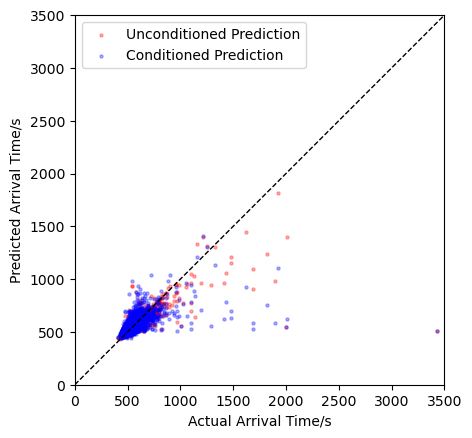

In [38]:
valid10 = valid0

pred1_10 = best_model1.predict(valid10)
pred0_10 = best_model1_conditonal_0.predict(valid10)

validpd1_10 = h2o.as_list(valid10)
predpd1_10 = h2o.as_list(pred1_10)
predpd0_10 = h2o.as_list(pred0_10)

plt.scatter(validpd1_10['arr_time'].tolist(), predpd1_10['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='red', label='Unconditioned Prediction')
plt.scatter(validpd1_10['arr_time'].tolist(), predpd0_10['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='blue', label='Conditioned Prediction')

plt.xlabel('Actual Arrival Time/s')
plt.ylabel('Predicted Arrival Time/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()
plt.savefig('unconditional_prediction_10', dpi=300)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


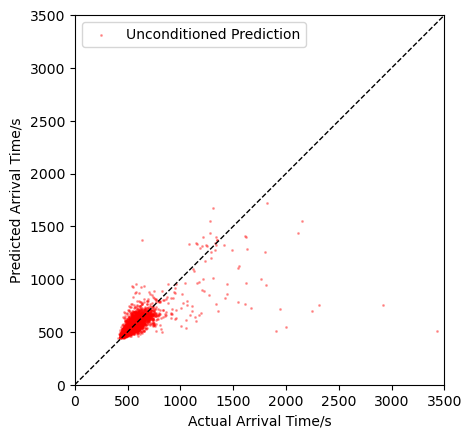

In [39]:
# retrieve the model performance
pred1 = best_model1.predict(valid)
validpd1 = h2o.as_list(valid)
predpd1 = h2o.as_list(pred1)

plt.scatter(validpd1['arr_time'].tolist(), predpd1['predict'].tolist(),  marker = '.', s=5, alpha=0.3, color='red', label='Unconditioned Prediction')

plt.xlabel('Actual Arrival Time/s')
plt.ylabel('Predicted Arrival Time/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()
plt.savefig('unconditional_prediction', dpi=300)

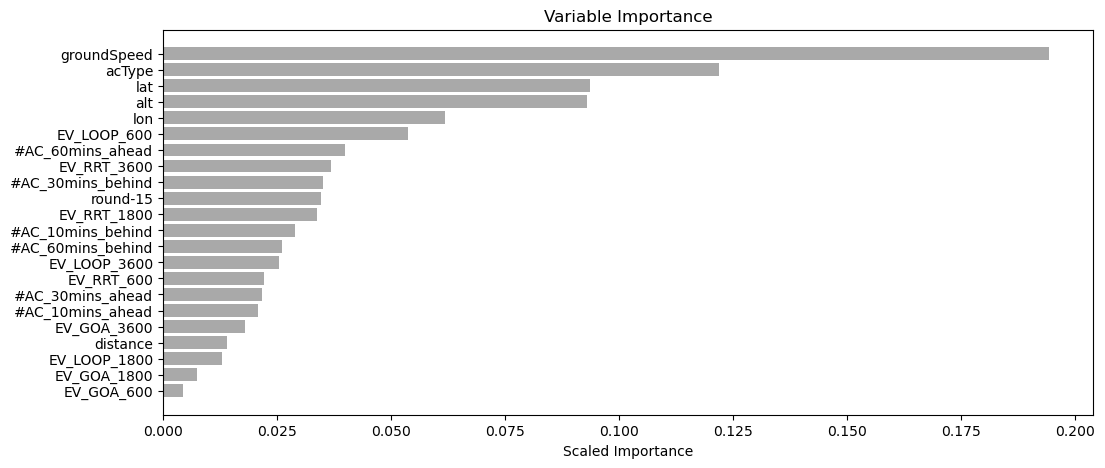

In [40]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12, 5))
variables = best_model1._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model1._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
fig.savefig('VI_unconditional', dpi=300)
plt.show()


## Conditional ML Predictor

In [ ]:
pdf3

In [ ]:
ts =  np.arange(400, 3200, 200).tolist()
avg600, avg1800, avg3600 = [], [], []
for idx in range(len(ts)-1):
    avg600.append(pdf3[(pdf3['arr_time']>ts[idx]) & (pdf3['arr_time']<ts[idx+1])]['EV_LOOP_600'].mean())
    print(f'Average EV_LOOP_600 for arr_time threshold [{ts[idx]}, {ts[idx+1]}]: {avg600[-1]}')

    avg1800.append(pdf3[(pdf3['arr_time']>ts[idx]) & (pdf3['arr_time']<ts[idx+1])]['EV_LOOP_1800'].mean())
    print(f'Average EV_LOOP_1800 for arr_time threshold [{ts[idx]}, {ts[idx+1]}]: {avg1800[-1]}')

    avg3600.append(pdf3[(pdf3['arr_time']>ts[idx]) & (pdf3['arr_time']<ts[idx+1])]['EV_LOOP_3600'].mean())
    print(f'Average EV_LOOP_3600 for arr_time threshold [{ts[idx]}, {ts[idx+1]}]: {avg3600[-1]}')

plt.scatter(ts[:-1], avg600, s=5, alpha=0.8, label='EV_LOOP_600', color='forestgreen')
plt.scatter(ts[:-1], avg1800, s=5, alpha=0.8, label='EV_LOOP_1800', color='cornflowerblue')
plt.scatter(ts[:-1], avg3600, s=5, alpha=0.8, label='EV_LOOP_3600', color='darkorange')

plt.plot(ts[:-1], avg600, linewidth=1, color='forestgreen')
plt.plot(ts[:-1], avg1800, linewidth=1, color='cornflowerblue')
plt.plot(ts[:-1], avg3600, linewidth=1, color='darkorange')

plt.ylabel('Number of LOOP Events Recorded')
plt.xlabel('Arrival Duration Range/s')
plt.legend()
plt.savefig('event_hist.png', dpi=300)

In [ ]:
ts =  np.arange(0, 80, 10).tolist()
avg600, avg1800, avg3600 = [], [], []
for idx in range(len(ts)-1):
    avg600.append(pdf3[(pdf3['EV_LOOP_600']>ts[idx]) & (pdf3['EV_LOOP_600']<ts[idx+1])]['arr_time'].mean())
    print(f'Average arr_time for EV_LOOP_600 threshold [{ts[idx]}, {ts[idx+1]}]: {avg600[-1]}')

    avg1800.append(pdf3[(pdf3['EV_LOOP_1800']>ts[idx]) & (pdf3['EV_LOOP_1800']<ts[idx+1])]['arr_time'].mean())
    print(f'Average arr_time for EV_LOOP_1800 threshold [{ts[idx]}, {ts[idx+1]}]: {avg1800[-1]}')

    avg3600.append(pdf3[(pdf3['EV_LOOP_3600']>ts[idx]) & (pdf3['EV_LOOP_3600']<ts[idx+1])]['arr_time'].mean())
    print(f'Average arr_time for EV_LOOP_3600 threshold [{ts[idx]}, {ts[idx+1]}]: {avg3600[-1]}')
fig, ax = plt.subplots()

plt.scatter(ts[:-1], avg600, s=5, alpha=0.8, label='EV_LOOP_600', color='forestgreen')
plt.scatter(ts[:-1], avg1800, s=5, alpha=0.8, label='EV_LOOP_1800', color='cornflowerblue')
plt.scatter(ts[:-1], avg3600, s=5, alpha=0.8, label='EV_LOOP_3600', color='darkorange')

plt.plot(ts[:-1], avg600, linewidth=1, color='forestgreen')
plt.plot(ts[:-1], avg1800, linewidth=1, color='cornflowerblue')
plt.plot(ts[:-1], avg3600, linewidth=1, color='darkorange')

ax.axvspan(10, 40, alpha=0.2, color='y')
ax.axvspan(40, 60, alpha=0.2, color='violet')
ax.axvspan(0, 10, alpha=0.2, color='grey')

#plt.axvline(x=10, ymin=0, ymax=1000, c='y')

plt.xlim(0, 60)
plt.ylabel('Averaged Arrival Time/s')
plt.xlabel('Number of LOOP Events Recorded')
plt.legend()
plt.savefig('arr_time_hist.png', dpi=300)

In [41]:
pdf3_conditional = pdf3[(pdf3['EV_LOOP_600']>10)&(pdf3['EV_LOOP_600']<40)]

In [42]:
pdf3_conditional

,Unnamed: 0,recTime,time,round-60,round-30,round-15,acId,lat,lon,alt,...,EV_LOOP_600,EV_LOOP_1800,EV_LOOP_3600,EV_GOA_600,EV_GOA_1800,EV_GOA_3600,arr_time,time200,time100,time40
318,552579,1564671279,2019-08-01 10:54:39,10,21,43,SWA2357,34.82583,-83.01250,302.0,...,11,17,34,0,0,1,511,1564670450,1564671279,1564671790
332,598367,1564672211,2019-08-01 11:10:11,11,22,44,NKS404,32.45500,-83.05528,281.0,...,11,27,38,1,2,3,524,1564671457,1564672211,1564672735
334,610528,1564672613,2019-08-01 11:16:53,11,22,45,DAL1113,33.43278,-82.45972,270.0,...,12,28,40,1,2,3,633,1564671712,1564672613,1564673246
336,613124,1564672583,2019-08-01 11:16:23,11,22,45,DAL2420,32.45778,-83.05833,247.0,...,11,29,39,1,2,3,537,1564671805,1564672583,1564673120
337,617007,1564672969,2019-08-01 11:22:49,11,22,45,DAL2609,34.68389,-82.86778,220.0,...,13,29,45,0,2,2,514,1564671963,1564672969,1564673483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,1463111,1567115421,2019-08-29 17:50:21,17,35,71,DAL1556,34.40583,-86.19611,252.0,...,15,40,64,0,2,6,473,1567114683,1567115421,1567115894
794,1660326,1567115167,2019-08-29 17:46:07,17,35,71,DAL2299,34.81750,-83.02111,271.0,...,15,40,66,1,3,6,518,1567114362,1567115167,1567115685
960,1950472,1567131362,2019-08-29 22:16:02,22,44,89,ASH6108,32.60361,-85.95944,290.0,...,11,18,21,1,3,4,549,1567130607,1567131362,1567131911
961,1950980,1567131476,2019-08-29 22:17:56,22,44,89,DAL2580,34.35361,-86.21306,295.0,...,12,20,23,1,3,4,486,1567130704,1567131476,1567131962


In [43]:
# h2o.cluster().shutdown()
h2o.init()
hf = h2o.H2OFrame(pdf3_conditional)
predictors = ['round-15', 'lat', 'lon', 'alt', 'Dest', 'distance', 'acType', 'groundSpeed', 'distance', 
            '#AC_10mins_ahead', '#AC_10mins_behind', '#AC_30mins_ahead', '#AC_30mins_behind', '#AC_60mins_ahead', '#AC_60mins_behind', 
            'EV_RRT_600', 'EV_RRT_1800', 'EV_RRT_3600', 'EV_LOOP_600', 'EV_LOOP_1800', 'EV_LOOP_3600', 'EV_GOA_600', 'EV_GOA_1800', 'EV_GOA_3600']
response = "arr_time"

valid2, train2 = hf.split_frame(ratios = [.2], seed = 1234)

# Grid Search Model
gbm_params1_conditonal = {'learn_rate': [0.05, 0.1],
                'max_depth': [7, 8, 9, 10, 11, 12],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 0.6, 0.7, 0.8]}

# Train and validate a cartesian grid of GBMs
gbm_grid1_conditonal = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid2',
                          hyper_params=gbm_params1_conditonal,
                          )

gbm_grid1_conditonal.train(x=predictors, 
                y=response,
                training_frame=train2,
                validation_frame=valid2,
                ntrees=100,
                seed=1234)

# show best grid
gbm_gridperf1_conditonal = gbm_grid1_conditonal.get_grid(sort_by='mae', decreasing=False)

best_model1_conditonal = gbm_gridperf1_conditonal.models[0]

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,22 mins 25 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 year and 25 days !!!
H2O_cluster_name:,H2O_from_python_ypang6_txvb3d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.95 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [44]:
gbm_gridperf1_conditonal

        col_sample_rate  learn_rate  max_depth  sample_rate  \
0                   0.6        0.05       12.0          1.0   
1                   0.6        0.10        9.0          1.0   
2                   0.8        0.05       12.0          0.8   
3                   0.6        0.05        8.0          1.0   
4                   0.5        0.05       11.0          1.0   
..  ..              ...         ...        ...          ...   
187                 0.5        0.10        7.0          0.8   
188                 0.8        0.10       11.0          0.8   
189                 0.8        0.10        9.0          0.8   
190                 0.6        0.10        8.0          0.8   
191                 0.6        0.10        7.0          0.8   

               model_ids        mae  
0     gbm_grid2_model_90  66.336244  
1     gbm_grid2_model_70  66.630498  
2     gbm_grid2_model_44  66.663418  
3     gbm_grid2_model_58  66.780119  
4    gbm_grid2_model_177  66.781945  
..             

In [45]:
valid2.shape

(637, 33)

In [46]:
perf1_conditonal = best_model1_conditonal.model_performance(valid2)
perf1_conditonal


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 27999.627953152103
RMSE: 167.33089360053063
MAE: 66.33624418696985
RMSLE: 0.15108980847872783
Mean Residual Deviance: 27999.627953152103


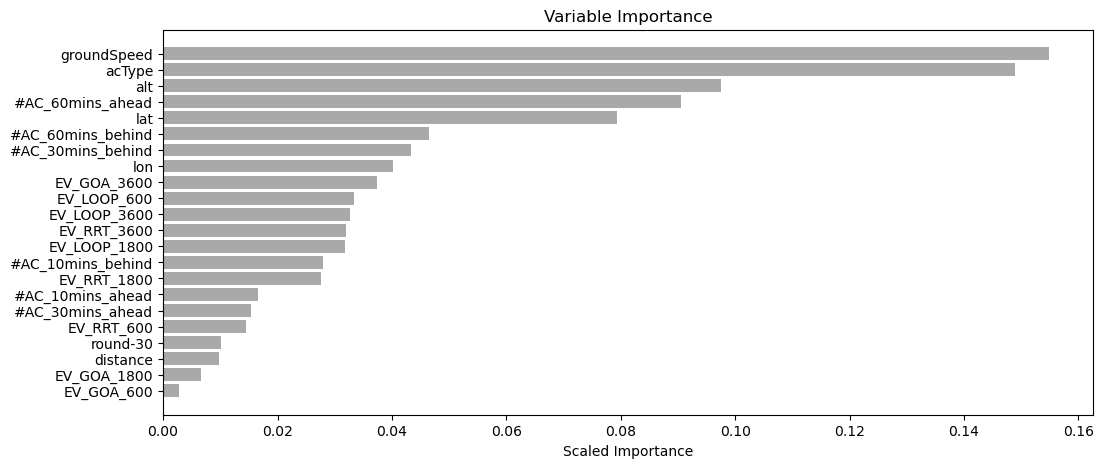

In [47]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,5))
variables = best_model1_conditonal._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model1_conditonal._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_conditional', dpi=300)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


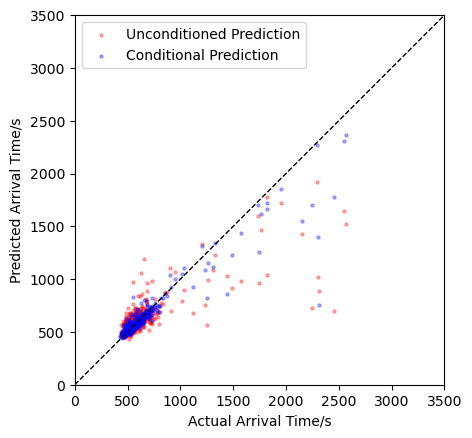

In [48]:
# retrieve the model performance
pred_conditional2 = best_model1_conditonal.predict(valid2)
validpd2 = h2o.as_list(valid2)
predpd2 = h2o.as_list(pred_conditional2)

pred1_10_40 = best_model1.predict(valid2)
predpd1_10_40 = h2o.as_list(pred1_10_40)

plt.scatter(validpd2['arr_time'].tolist(), predpd2['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='red', label='Unconditioned Prediction')
plt.scatter(validpd2['arr_time'].tolist(), predpd1_10_40['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='blue', label='Conditional Prediction')

plt.xlabel('Actual Arrival Time/s')
plt.ylabel('Predicted Arrival Time/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()

plt.savefig('compare_filter_ev_600_loop.png', dpi=300)

### filter EV_LOOP_600 > 40


In [49]:
pdf3_conditional_2 = pdf3[pdf3['EV_LOOP_600']>40]
# h2o.cluster().shutdown()
h2o.init()
hf = h2o.H2OFrame(pdf3_conditional_2)
predictors = ['round-15', 'lat', 'lon', 'alt', 'Dest', 'distance', 'acType', 'groundSpeed', 'distance', 
            '#AC_10mins_ahead', '#AC_10mins_behind', '#AC_30mins_ahead', '#AC_30mins_behind', '#AC_60mins_ahead', '#AC_60mins_behind', 
            'EV_RRT_600', 'EV_RRT_1800', 'EV_RRT_3600', 'EV_LOOP_600', 'EV_LOOP_1800', 'EV_LOOP_3600', 'EV_GOA_600', 'EV_GOA_1800', 'EV_GOA_3600']
response = "arr_time"

valid3, train3 = hf.split_frame(ratios = [.2], seed = 1234)

# Grid Search Model
gbm_params1_conditonal_2 = {'learn_rate': [0.05, 0.1],
                'max_depth': [7, 8, 9, 10, 11, 12],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 0.6, 0.7, 0.8]}
                
# Train and validate a cartesian grid of GBMs
gbm_grid1_conditonal_2 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid3',
                          hyper_params=gbm_params1_conditonal_2,
                          )

gbm_grid1_conditonal_2.train(x=predictors, 
                y=response,
                training_frame=train3,
                validation_frame=valid3,
                ntrees=100,
                seed=1234)

# show best grid
gbm_gridperf1_conditonal_2 = gbm_grid1_conditonal_2.get_grid(sort_by='mae', decreasing=False)

best_model1_conditonal_2 = gbm_gridperf1_conditonal_2.models[0]

perf1_conditonal_2 = best_model1_conditonal_2.model_performance(valid3)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,23 mins 54 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 year and 25 days !!!
H2O_cluster_name:,H2O_from_python_ypang6_txvb3d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.88 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [50]:
perf1_conditonal_2


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 26391.77643484884
RMSE: 162.45545984930405
MAE: 106.69352611879842
RMSLE: 0.18634680748312193
Mean Residual Deviance: 26391.77643484884


In [51]:
valid3.shape

(38, 33)

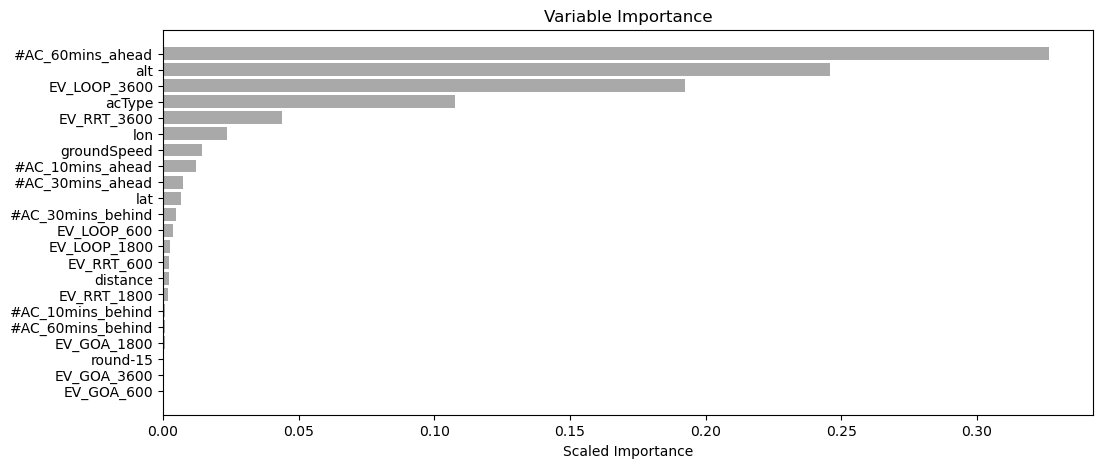

In [52]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,5))
variables = best_model1_conditonal_2._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model1_conditonal_2._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_conditional_2',dpi=300)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


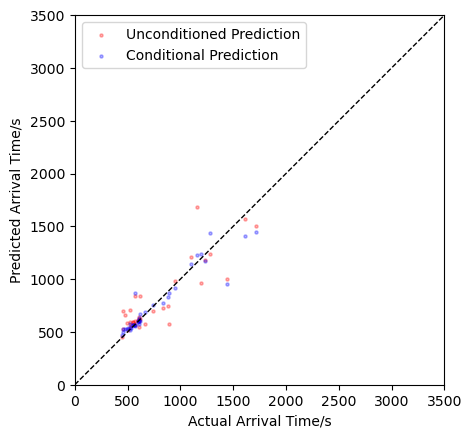

In [53]:
# retrieve the model performance
pred3 = gbm_gridperf1_conditonal_2.models[0].predict(valid3)
validpd3 = h2o.as_list(valid3)
predpd3 = h2o.as_list(pred3)

pred_40 = gbm_gridperf1.models[0].predict(valid3)
predpd_40 = h2o.as_list(pred_40)

plt.scatter(validpd3['arr_time'].tolist(), predpd3['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='red', label='Unconditioned Prediction')
plt.scatter(validpd3['arr_time'].tolist(), predpd_40['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='blue', label='Conditional Prediction')

plt.xlabel('Actual Arrival Time/s')
plt.ylabel('Predicted Arrival Time/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()

plt.savefig('compare_filter_ev_600_loop_40.png', dpi=300)

# Averaged Conditional Prediction Results

In [54]:
# round-30
# re2 = {'MSE': 27999.627953152103,
# 'RMSE': 167.33089360053063,
# 'MAE': 66.33624418696985,
# 'RMSLE': 0.15108980847872783,
#     }

# re3 = {
#     'MSE': 27082.404731153543,
# 'RMSE': 164.56732583096058,
# 'MAE': 109.57216649418756,
# 'RMSLE': 0.189383790894846,
# }

# re1 = {'MSE': 6749.333952660869,
# 'RMSE': 82.15433009075583,
# 'MAE': 34.16417732212681,
# 'RMSLE': 0.09517193967977966}


# round-15
re2 = {'MSE': 27999.627953152103,
'RMSE': 167.33089360053063,
'MAE': 66.33624418696985,
'RMSLE': 0.15108980847872783,
    }

re3 = {
    'MSE': 26391.77643484884,
'RMSE': 162.45545984930405,
'MAE': 106.69352611879842,
'RMSLE': 0.18634680748312193
}

re1 = {'MSE': 6936.839657381721,
'RMSE': 83.28769211223062,
'MAE': 34.22468155332629,
'RMSLE': 0.09599901288284537}


In [55]:
for key in ['RMSE', 'MAE', 'RMSLE']:
    re = re2[key]*valid2.shape[0]+re1[key]*valid0.shape[0]+re3[key]*valid3.shape[0]
    print(f'The Averaged {key} for Conditional Predictor is {re/valid.shape[0]}')

The Averaged RMSE for Conditional Predictor is 91.49311630905561
The Averaged MAE for Conditional Predictor is 37.59184525942883
The Averaged RMSLE for Conditional Predictor is 0.10075948731320782


## Quantile Regression pf GBM
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html

In [ ]:
h2o.init()
hf = h2o.H2OFrame(pdf3)
predictors = ['hour', 'lat', 'lon', 'alt', 'Dest', 'distance', 'acType', 'groundSpeed', 'distance', 
            '#AC_10mins_ahead', '#AC_10mins_behind', '#AC_30mins_ahead', '#AC_30mins_behind', '#AC_60mins_ahead', '#AC_60mins_behind', 
            'EV_RRT_600', 'EV_RRT_1800', 'EV_RRT_3600', 'EV_LOOP_600', 'EV_LOOP_1800', 'EV_LOOP_3600', 'EV_GOA_600', 'EV_GOA_1800', 'EV_GOA_3600', ]
response = "arr_time"

valid, train = hf.split_frame(ratios = [.2], seed = 1234)

best_model_down = H2OGradientBoostingEstimator(distribution = "quantile", 
                                               #quantile_alpha = 0.164, 
                                               quantile_alpha = 0.80, 
                                               seed = 1234,
                                               col_sample_rate=0.6,
                                               learn_rate=0.05,
                                               max_depth=10, 
                                               sample_rate=1.0)
best_model_down.train(x = predictors,
                      y = response,
                      training_frame = train,
                      validation_frame = valid)

pred_low = best_model_down.predict(valid)

In [ ]:
best_model_down.model_performance(valid)

In [ ]:
best_model_up = H2OGradientBoostingEstimator(distribution = "quantile", 
                                             quantile_alpha = 0.7, 
                                            #  quantile_alpha = 0.837, 
                                             seed = 1234,
                                             col_sample_rate=0.6,
                                             learn_rate=0.05,
                                             max_depth=10, 
                                             sample_rate=1.0)
best_model_up.train(x = predictors,
                    y = response,
                    training_frame = train,
                    validation_frame = valid)

pred_up = best_model_up.predict(valid)

In [ ]:
fig, ax= plt.subplots(figsize=(20, 10))
validpd = h2o.as_list(valid)
x = np.arange(len(validpd))

_ = range(valid.shape[0])
plt.scatter(_, validpd['arr_time'].tolist(), marker = '.', label='GTs', s=5, alpha=0.8)

err_down = np.array(h2o.as_list(pred_low)['predict'])
err_up = np.array(h2o.as_list(pred_up)['predict'])

pred_m = (err_down+err_up)*0.5
_ = range(len(pred_m))
yerror = [err_down - pred_m, err_up-pred_m]
plt.scatter(_, pred_m, marker = '.', label='Predictions', s=5, alpha=0.8)

plt.fill_between(x, err_down, err_up, color='gray', alpha=0.2, label='prediction interval')
plt.legend()
plt.ylabel('Arrival Time')
plt.xlabel('Data Number')
fig.savefig('MLPrediction', dpi=300)

In [ ]:
plt.scatter(validpd['arr_time'].tolist(), pred_m,  marker = '.', s=5, alpha=0.8, label='Unconditioned Prediction')
plt.fill_between(validpd['arr_time'].tolist(), err_down, err_up, color='gray', alpha=0.2, label='prediction interval')

plt.xlabel('GTs')
plt.ylabel('Predictions')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()

In [ ]:
fig, ax= plt.subplots(figsize=(20, 10))
validpd = h2o.as_list(valid)
x = np.arange(len(validpd))

st = 2000
end = 3000

_ = range(valid.shape[0])
#plt.scatter(_[st:end], validpd['arr_time'].tolist()[st:end], marker = '.', label='GTs', s=5, alpha=0.8)
plt.plot(_[st:end], validpd['arr_time'].tolist()[st:end], marker = '.', label='GTs', alpha=0.8, linewidth=0.3)

err_down = np.array(h2o.as_list(pred_low)['predict'])
err_up = np.array(h2o.as_list(pred_up)['predict'])

pred_m = (err_down+err_up)*0.5
_ = range(len(pred_m))
yerror = [err_down - pred_m, err_up-pred_m]
#plt.scatter(_[st:end], pred_m[st:end], marker = '.', label='Predictions', s=5, alpha=0.8)
plt.plot(_[st:end], pred_m[st:end], marker = '.', label='Predictions', linewidth=0.3, alpha=0.8)

plt.fill_between(x[st:end], err_down[st:end], err_up[st:end], color='gray', alpha=0.2, label='C.I.')
plt.legend()
plt.ylabel('Arrival Time')
plt.xlabel('Data Number')
fig.savefig('MLPrediction-Zoom', dpi=300)

#### Feature Importance

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))
variables = best_model_up._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model_up._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_lower',dpi=300)

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))
variables = best_model_down._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model_down._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_lower',dpi=300)

# Optimization pipeline

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import Window

myschema = StructType([
        # 1  //track point record type number
        StructField("recType", ShortType(), True),
        # 2  //seconds since midnigght 1/1/70 UTC
        StructField("recTime", StringType(), True),
        StructField("fltKey", LongType(), True),  # 3  //flight key
        # 4  //digit range from 0 to 7
        StructField("bcnCode", IntegerType(), True),
        StructField("cid", IntegerType(), True),  # 5  //computer flight id
        StructField("Source", StringType(), True),  # 6  //source of the record
        StructField("msgType", StringType(), True),  # 7
        StructField("acId", StringType(), True),  # 8  //call sign
        StructField("recTypeCat", StringType(), True),  # 9
        StructField("lat", DoubleType(), True),  # 10
        StructField("lon", DoubleType(), True),  # 11
        StructField("alt", DoubleType(), True),  # 12  //in 100s of feet
        # 13 //digit range from 1 to 10
        StructField("significance", ShortType(), True),
        StructField("latAcc", DoubleType(), True),  # 14
        StructField("lonAcc", DoubleType(), True),  # 15
        StructField("altAcc", DoubleType(), True),  # 16
        StructField("groundSpeed", IntegerType(), True),  # 17 //in knots
        # 18  //in degrees from true north
        StructField("course", DoubleType(), True),
        # 19  //in feet per minute
        StructField("rateOfClimb", DoubleType(), True),
        # 20  //Altitude qualifier (the “B4 character”)
        StructField("altQualifier", StringType(), True),
        # 21  //Altitude indicator (the “C4 character”)
        StructField("altIndicator", StringType(), True),
        # 22  //Track point status (e.g., ‘C’ for coast)
        StructField("trackPtStatus", StringType(), True),
        # 23  //int 0-8 representing the direction of the leader line
        StructField("leaderDir", IntegerType(), True),
        StructField("scratchPad", StringType(), True),  # 24
        # 25 // MSAW Inhibit Indicator (0=not inhibited, 1=inhibited)
        StructField("msawInhibitInd", ShortType(), True),
        StructField("assignedAltString", StringType(), True),  # 26
        StructField("controllingFac", StringType(), True),  # 27
        StructField("controllingSec", StringType(), True),  # 28
        StructField("receivingFac", StringType(), True),  # 29
        StructField("receivingSec", StringType(), True),  # 30
        # 31  // the active control number
        StructField("activeContr", IntegerType(), True),
        # 32  //The primary(previous, controlling, or possible next)controller number
        StructField("primaryContr", IntegerType(), True),
        # 33  //identifies a subset of controller keyboards
        StructField("kybrdSubset", StringType(), True),
        # 34  //identifies a keyboard within the keyboard subsets
        StructField("kybrdSymbol", StringType(), True),
        # 35  //arrival departure status code
        StructField("adsCode", IntegerType(), True),
        # 36  //Operations type (O/E/A/D/I/U)from ARTS and ARTS 3A data
        StructField("opsType", StringType(), True),
        StructField("airportCode", StringType(), True),  # 37
        StructField("trackNumber", IntegerType(), True),  # 38
        StructField("tptReturnType", StringType(), True),  # 39
        StructField("modeSCode", StringType(), True),  # 40
        # 41 //a list of sensor/track number combinations
        StructField("sensorTrackNumberList", StringType(), True),
        # 42 // representing the Ident feature
        StructField("spi", StringType(), True),
        # 43 // indicate the aircraft is within a suppresion volumn area
        StructField("dvs", StringType(), True),
        # 44 // indicate 2 aircraft have the same mode 3a code
        StructField("dupM3a", StringType(), True),
        # 45 //Aircraft Ident entered by pilot
        StructField("tid", StringType(), True),
    ])

spark = SparkSession.builder\
    .appName("Terminal_Area_Flight_Data_Query")\
    .config("spark.driver.memory", "50g")\
    .config("spark.driver.maxResultSize", "50g")\
    .getOrCreate()


date_ls = [20190801]

file_path = f"/media/ypang6/paralab/Research/data/{sector}/"
file_dir = []
for date in date_ls:
    file_names = f'IFF_{sector}_{date}*.csv'
    file_dir.append(glob.glob(file_path+file_names)[0])

df = spark.read.csv(file_dir, header=False, sep=",", schema=myschema)
cols = ['recType', 'recTime', 'acId', 'lat', 'lon', 'alt', 'groundSpeed']
df_rec3 = df.select(*cols).filter(df['recType']==3).withColumn("recTime", df['recTime'].cast(IntegerType()))

pdf_rec3 = df_rec3.toPandas()

pdf_rec3['next_acId'] = pdf_rec3['acId'].shift(-1)
pdf_rec3['previous_acId'] = pdf_rec3['acId'].shift(1)
pdf_rec3['init_ac'] = pdf_rec3['acId'] != pdf_rec3['previous_acId']
pdf_rec3['end_ac'] = pdf_rec3['acId'] != pdf_rec3['next_acId']
pdf_rec3.drop(columns=['previous_acId', 'next_acId'])

pdf_rec3.count()

file_path = glob.glob('../data_preprocessing/processed_features/{}*'.format(sector))
pdf3 = pd.concat(map(pd.read_csv, file_path))

In [ ]:
#time_interval = [1564680000, 1564680000+25*60]# 13:20 - 13:36 for case study 1 
time_interval = [1564689600, 1564689600+3600] #16:00 - 16:30 for case study 2
#time_interval = [1564707600, 1564707600+1200] #21:00 - 21:20 for case study 3

busy = pdf3.loc[pdf3['recTime'].between(time_interval[0],time_interval[1])]
busy_runway1 = []
land_t = []

for index, row in busy.iterrows():
    acTr = pdf_rec3.loc[pdf_rec3['acId']==row['acId']]
    end_row = acTr.loc[acTr['end_ac']==True]
    check = end_row.loc[end_row['lat'].between(33.64, 33.65)]
    check = check.loc[check['recTime'].between(time_interval[0],time_interval[1]+3600)]
    if check.empty:
        continue
    busy_runway1.append(row['acId'])
    end_rows = acTr.loc[check.index[0]-20:check.index[0]]
    end_rows = end_rows.loc[end_rows['alt']==check['alt'].values[0]]
    land_t.append(end_rows.head(1)['recTime'].values[0])
    
busy = busy[busy['acId'].isin(busy_runway1)]
busy['land_t'] = land_t

time200 = busy['time200'].copy()
time100 = busy['time100'].copy()
time40 = busy['time40'].copy()
time0 = busy['land_t'].copy()
fig, ax = plt.subplots(figsize=(10, 7))

cmap = plt.cm.get_cmap('tab20', len(time200))
for i, time in enumerate(time200):
    time200_tmp = time-min(time200)
    time100_tmp = time100.values[i]-min(time100)
    time40_tmp = time40.values[i]-min(time40)
    time0_tmp = time0.values[i] - min(time0)

    # ar1 = plt.arrow(time200_tmp, 200, time100_tmp-time200_tmp, -100)
    # ar2 = plt.arrow(time100_tmp, 100, time40_tmp-time100_tmp, -60)
    # ar3 = plt.arrow(time40_tmp, 40, time0_tmp - time40_tmp, -40)
    # ax.add_artist(ar1)
    # ax.add_artist(ar2)
    # ax.add_artist(ar3)
    plt.plot([time200_tmp, time100_tmp], [200, 100], color=cmap(i), label=list(busy['acId'])[i])
    plt.plot([time100_tmp, time40_tmp], [100, 40], color=cmap(i))
    plt.plot([time40_tmp, time0_tmp], [40, 0], color=cmap(i))

    ax.scatter(time200_tmp, 200, marker='d', color='black')
    ax.scatter(time100_tmp, 100, marker='d', color='black')
    ax.scatter(time40_tmp, 40, marker='d', color='black')
    ax.scatter(time0_tmp, 0, marker='d', color = 'black')
plt.legend()
plt.xlabel('Relative Time Spent $\Delta T$ (second)', fontsize=15)
plt.ylabel('Distance to ATL (nm)', fontsize=15)
plt.savefig(f'truth_{date}', dpi=300)


slice_data = busy
slice_data[['acId', 'acType']]


In [ ]:
slice_data_hf = h2o.H2OFrame(slice_data)
slice_pred_up = best_model_up.predict(slice_data_hf)
slice_pred_down = best_model_down.predict(slice_data_hf)

true_data = slice_data['arr_time'].values
err_pred_down = np.array(h2o.as_list(slice_pred_down)['predict'])
err_pred_up = np.array(h2o.as_list(slice_pred_up)['predict'])
slice_pred = (err_pred_down + err_pred_up)/2
_ = range(len(slice_pred))
yerror = [slice_pred - err_pred_down, err_pred_up-slice_pred]
plt.errorbar(_, slice_pred, yerr=yerror, fmt='b', elinewidth=1, capsize=5, barsabove=True, ls='none')

marker = ['o','s','v','^','D','<','>','h','H','p','*','8','P','d','X','x']
for i in range(len(true_data)):
    rgb = np.random.rand(3,)
    plt.scatter(_[i], slice_pred[i], marker='s', color=[rgb], label = slice_data['acId'].values[i])
    plt.scatter(_[i], true_data[i], marker='o', color = [rgb])
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))


In [ ]:
(err_pred_up -err_pred_down)/2

In [ ]:
plt.figure(figsize=(6,5))
for index, row in slice_data.iterrows():
    id = row['acId']
    tr = pdf_rec3.loc[pdf_rec3['acId']==id]

    if id == 'DAL2794':
        start_idx = tr.index[0]
        interval_idx = tr['recTime'].diff().argmax()
        tr = tr.iloc[interval_idx:]

    time = row['recTime']
    dest = row['Dest']
    tr = tr.loc[tr['recTime'].between(time, time+3000)]
    plt.scatter(tr['lon'][-50:], tr['lat'][-50:], marker = '.', s=10, label=id)
    j = np.random.randint(len(slice_data))
    plt.text(tr['lon'].values[-50+j//2],tr['lat'].values[-50+j//2], id, rotation='vertical',fontsize=6)
    #plt.scatter(airportsCoord[dest][1], airportsCoord[dest][0], marker = '*', color='r', s = 200)
    #for index, row in tr.iterrows():
        #distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
        #if distance2airport<74080:
            #plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
            #break
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('landing_trj.png', dpi=300)

In [ ]:
slice_data['acType']

In [ ]:
from pyomo.environ import *
import numpy as np
import sys
from DistributionATSP import Distribution_ATSP
from scipy.stats import norm
import matplotlib.pyplot as plt
import random as rd
import pandas as pd

runway3 = busy_runway1

def time_space(threshold, sd1, sd2):
    return threshold - norm.ppf(q = Pc, loc = 0,scale = np.sqrt(sd1**2 + sd2**2))

Pc = 0.1
UB = [100000]
LB = [0]
tt = [0]
items = ['acId', 'threshold', 'mean', 'sd', 'uperBound', 'lowerBound']
ac = pd.DataFrame([], columns=items)
ac['acId'] = runway3
#ac['mean']= runway3_arr_time
ac.loc[:,'threshold'] = 64

r3_time = slice_data['recTime'].copy()
r3_time -= min(r3_time)
r3_time.values


#for id in slice_data['acId'].values:
    #check.append(id in runway3)
r3_pred = np.array(slice_pred)
#ac['mean'] = slice_data[check]['arr_time'].values

ac['mean'] = r3_pred + r3_time.values
ac['sd'] = abs(np.array(err_pred_up) - r3_pred)
ac['lowerBound'] = ac['mean'] - 60
ac['uperBound'] = ac['mean'] + 600
ac.loc[ac[ac['lowerBound']<0].index, 'lowerBound']=0

ac['acType'] = slice_data['acType'].values

In [ ]:
ac

In [ ]:
r3_pred

In [ ]:
runway3

In [ ]:
ac=ac.drop('acType', axis=1)
runway3 = slice_data['acId'].values
max_num = min(len(runway3), 9)

gap = (len(runway3) - max_num) // 2
ac_runway3 = runway3[gap:-gap]
ac_runway3 = runway3[:max_num]


check2 = []
for id in ac['acId'].values:
    check2.append(id in ac_runway3)
ac = ac[check2]
ac

In [ ]:
ac['acId'].values

In [ ]:
plt.figure(figsize=(6,6))

for index, row in slice_data.iterrows():
    id = row['acId']
    if id in ac_runway3:
        tr = pdf_rec3.loc[pdf_rec3['acId']==id]
        if id == 'DAL2794':
            start_idx = tr.index[0]
            interval_idx = tr['recTime'].diff().argmax()
            tr = tr.iloc[interval_idx:]

        time = row['recTime']
        dest = row['Dest']
        tr = tr.loc[tr['recTime'].between(time,time+3000)] # 3000 for case I, 10000 for case 2
        plt.scatter(tr['lon'][-50:], tr['lat'][-50:], marker = 'o', s=5, alpha=0.5, label=id)

        j = np.random.randint(len(slice_data))
        plt.text(tr['lon'].values[-50+j//2], tr['lat'].values[-50+j//2], id, rotation='vertical',fontsize=6)

plt.legend(loc='upper left')
plt.tight_layout()
plt.xlabel('Longitude/$^o$')
plt.ylabel('Latitude/$^o$')
plt.savefig('landing_trj_1.png', dpi=300)


In [ ]:
ac = ac.reset_index(drop=True)
ac

In [ ]:
from DistributionATSP import Distribution_ATSP

tt = np.array([0])
tt = np.append(tt, np.array(ac['mean'].tolist()))
num_ac = len(ac_runway3)
for index, row in ac.iterrows():
    LB.append(row['lowerBound'])
    UB.append(row['uperBound'])
    tt_temp = [0]
    for ii in range(num_ac):
        if index == ii:
            space = 0
        else:
            space = time_space(row['threshold'], row['sd'], ac.loc[ii]['sd']) 
        tt_temp.append(space)
    tt=np.vstack((tt, np.array(tt_temp)))

N = num_ac
ccc = Distribution_ATSP(UB, LB, N, tt)
model = ccc.set_model()

solver = SolverFactory('glpk')
solution = solver.solve(model, tee=True)
result_time = np.zeros(N)
for i in range(N):
    result_time[i] = model.t[i+2].value
sort_index = np.argsort(result_time)
sort_time = np.sort(result_time)
sort_index
sort_time

In [ ]:
ttpd=pd.DataFrame(tt)
ttpd

In [ ]:
sort_time

In [ ]:
ac = ac.reindex(sort_index)
sort_index

In [ ]:
marker = ['o','s','v','^','D','d','p','P', 'x']
#marker = ['o','s','v','^','D','d','p','P']
#marker = ['o','s','v','^','D','<','>','h','H','p','*','8','P','d','X','x']
color = np.random.rand(9, 3)
#ac_indicator = pd.DataFrame()
ac_indicator = ac[['acId']].copy()
ac_indicator['marker'] = marker
ac_indicator['color'] = color.tolist()
ac_indicator

In [ ]:
land_time = []
time_40 = []
time_100 = []
time_200 = []
ac_runway3 = ac_indicator['acId'].values
for id in ac_runway3:
    land_time.append(slice_data.loc[slice_data['acId']==id]['land_t'].values[0])
    time_40.append(slice_data.loc[slice_data['acId']==id]['time40'].values[0])
    time_100.append(slice_data.loc[slice_data['acId']==id]['time100'].values[0])
    time_200.append(slice_data.loc[slice_data['acId']==id]['time200'].values[0])

ac_indicator['land_time'] = land_time
ac_indicator['time40'] = time_40
ac_indicator['time100'] = time_100
ac_indicator['time200'] = time_200
ac_indicator['sort_time'] = sort_time
#ac_indicator['sort_time'] = np.zeros(ac_indicator.shape[0])
#for i in range(ac_indicator.shape[0]):
#    ac_indicator.loc[i,'sort_time'] = sort_time[i]
ac_indicator

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
for i in range(len(ac_runway3)):
    plt.scatter(ac_indicator['time200'][i]-min(ac_indicator['time200']), 200, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time100'][i]-min(ac_indicator['time100']), 100, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time40'][i]-min(ac_indicator['time40']), 40, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['land_time'][i]-min(ac_indicator['land_time']), 10, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['sort_time'][i]-min(ac_indicator['sort_time']), 0, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i], label = ac_indicator['acId'][i])
    ar0 = plt.arrow(ac_indicator['time200'][i]-min(ac_indicator['time200']), 200, ac_indicator['time100'][i]-min(ac_indicator['time100']) - (ac_indicator['time200'][i]-min(ac_indicator['time200'])), -100)
    ar1 = plt.arrow(ac_indicator['time100'][i]-min(ac_indicator['time100']), 100, ac_indicator['time40'][i]-min(ac_indicator['time40']) - (ac_indicator['time100'][i]-min(ac_indicator['time100'])), -60)
    ar2 = plt.arrow(ac_indicator['time40'][i]-min(ac_indicator['time40']), 40, ac_indicator['land_time'][i]-min(ac_indicator['land_time']) - (ac_indicator['time40'][i]-min(ac_indicator['time40'])), -30)                
    ar3 = plt.arrow(ac_indicator['time200'][i]-min(ac_indicator['time200']), 200, ac_indicator['sort_time'][i]-min(ac_indicator['sort_time']) - (ac_indicator['time200'][i]-min(ac_indicator['time200'])),-200,linestyle=':', color = 'r')

    ax.add_artist(ar1)
    ax.add_artist(ar2)
    ax.add_artist(ar3)
    
plt.legend(loc='upper right')
plt.xlabel('Relevant Times/s')

y = [0, 10, 40, 100, 200]
yticks = ['Proposed', 'FCFS', '40NM', '100NM', '200NM']
plt.yticks(y, yticks, rotation = 'horizontal')
plt.savefig('absolute_time_results.png', dpi=300)

In [ ]:
first_acTime = min(ac_indicator['land_time'])
first_acTime

In [ ]:
from datetime import timedelta
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize = (15,5))
bias = min(ac_indicator['land_time']) - min(ac_indicator['sort_time'])


for i in range(len(ac_runway3)):
    plt.scatter(ac_indicator['time200'][i], 200, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time100'][i], 100, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time40'][i], 40, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['land_time'][i], 10, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])

    plt.scatter(ac_indicator['sort_time'][i] + bias, 0, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i], label = ac_indicator['acId'][i])
    
    ar0 = plt.arrow(ac_indicator['time200'][i], 200, ac_indicator['time100'][i] - ac_indicator['time200'][i], -100, linewidth = 0.5)
    ar1 = plt.arrow(ac_indicator['time100'][i], 100, ac_indicator['time40'][i] - ac_indicator['time100'][i], -60, linewidth = 0.5)
    ar2 = plt.arrow(ac_indicator['time40'][i], 40, ac_indicator['land_time'][i]- ac_indicator['time40'][i], -30, linewidth = 0.5)                
    ar3 = plt.arrow(ac_indicator['time200'][i], 200, ac_indicator['sort_time'][i] + bias - ac_indicator['time200'][i],-200,linestyle='-', color = 'red', alpha=0.5)

    ax.add_artist(ar1)
    ax.add_artist(ar2)
    ax.add_artist(ar3)
    
plt.xlabel('Estimated/Original Landing Times in UTC-4/s')
l1 = plt.legend()
y = [0, 10, 40, 100, 200]
yticks = ['0(Proposed)', '0(FCFS)', '40', '100', '200']
plt.yticks(y, yticks, rotation = 'horizontal')
plt.ylabel('Distance to Landing/NM')

xtickslocs = ax.get_xticks()
xticks = [str(x).split("+")[0].split(" ")[-1] for x in pd.to_datetime(xtickslocs, unit='s', utc='True') - timedelta(hours=4)]
ax.set_xticklabels(xticks)
#plt.xticks(rotation=45)

ax.add_artist(l1)

red_patch = mpatches.Patch(color='red', label='The Proposed Method')
blue_patch = mpatches.Patch(color='black', label='The History Data with FCFS Rule')
plt.legend(handles=[blue_patch,red_patch], loc='lower left')

fig.savefig('result-1.png', dpi=300)


In [ ]:
from datetime import timedelta
[str(x) for x in pd.to_datetime(ac_indicator['sort_time'] + bias, unit='s', utc='True') - timedelta(hours=4)]